In [2]:
import gym
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

## Plotting Function

In [3]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## Deep Q Learning

In [4]:
def build_mlp_model(input_size, hidden_size,
                   output_size,loss='mse',optimizer=Adam()):
    model=Sequential()
    model.add(Dense(units=hidden_size,input_dim=input_size, 
                    activation='relu'))
    model.add(Dense(units=hidden_size*2, activation='relu'))
    model.add(Dense(units=output_size, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model


#Implement DQN with keras
class DQN_keras():
    def __init__(self, build_func, input_size,
                hidden_size, output_size):
        self.model=build_func(input_size, hidden_size, output_size)
        
    def update(self, state, y):
        """Update the weighs of the network 
           given a training sample
        args:
          state: the input to predict
          y: the label
        """
        self.model.fit(np.array([state]), np.array([y]), verbose=0)
        
    def predict(self, state):
        """Compute Q values for all actions of one state
           of a state 
        """
        return self.model.predict(np.array([state]))[0]
    
    def replay(self, memory, size, gamma=0.9):
        """Add experience replay to the DQN network class"""
        #Make sure the memory is big enough
        if len(memory)>=size:
            states = []
            targets = []
            #Sample a batch of experiences from the agent's memory
            batch = random.sample(memory, size)
            
            #Extract information from the data
            for state, action, next_state, reward, done in batch:
                states.append(state)
                q_values = self.predict(state)
                q_values_list = q_values.tolist()
                if done:
                    q_values_list[action]=reward
                else:
                    q_values_next=self.predict(next_state)
                    q_values_list[action]=reward+gamma*np.max(q_values_next)
                    
                targets.append(np.array(q_values_list))
            
            states = np.array(states)
            targets = np.array(targets)
            
            
            self.model.fit(states, targets, verbose=0)

In [6]:
def q_learning_keras(env, model, episodes, gamma=0.9,
                    epsilon=0.3, eps_decay=0.99,
                    replay=False, replay_size=20, title='DQN'):
    """Deep Q Learning Algorithm using DQN"""
    final=[] #to store total rewards of every game
    memory=[] #to store replay experience
    
    for episode in range(episodes):
        # reset state
        state = env.reset()
        #print("type of state: ", type(state))
        #print("shape of state: ", state.shape)
        #print("state: ", state)
        #print(np.array([state]))
        done = False
        total=0
        
        while not done:
            # epsilon-greedy 
            if  random.random()<epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = np.argmax(q_values)
                
            #Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            #Update total rewards memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state)
            q_values_list = q_values.tolist()
            
            if done:
                if not replay:
                    q_values_list[action]=0
                    #Update network weights using q_values_list as label
                    model.update(state, q_values)
                    break
                    
            if replay:
                #Update network weights using replay buffer
                model.replay(memory, replay_size, gamma)
                
            else:
                #Update network weights using the last step
                q_values_next = model.predict(next_state)
                q_values[action]=reward+gamma*np.max(q_values_next)
                model.update(state, q_values)#use new q_values as the label
                
            state = next_state
            
        #Update epsilon
        epsilon = max(epsilon*eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
    return final
                

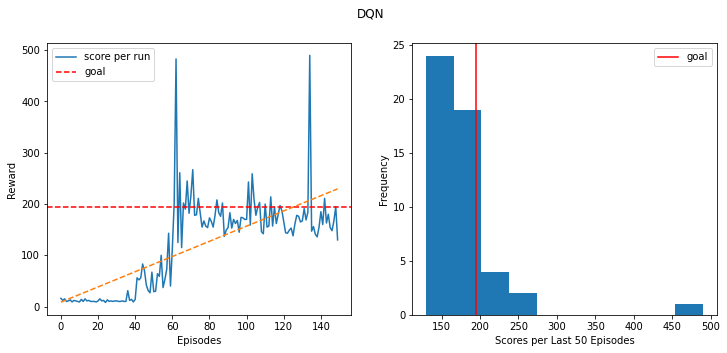

In [9]:
env = gym.envs.make("CartPole-v1")


n_state = env.observation_space.shape[0]
#Number of states
n_action = env.action_space.n
#Number of actions
episodes = 150
n_hidden = 50

dqn_keras = DQN_keras(build_mlp_model, n_state, n_hidden, n_action)
rewards_episodes = q_learning_keras(env, dqn_keras, episodes, replay=True)